In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from DataLoader import DataLoader
import cv2
import numpy as np

n_images = 30

class_merge_map = {9:8, 13:8}
data_loader = DataLoader(class_merge_map=class_merge_map)
data_loader.load_data(n_images*3)

In [2]:
image, mask = data_loader.get_image(0)

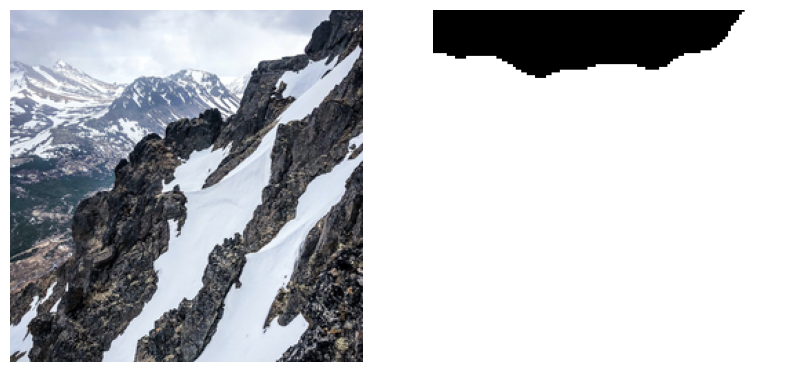

In [3]:
def compare_images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image1, cmap='gray' if image.ndim == 2 else None)
    axes[0].axis('off')
    axes[1].imshow(image2, cmap='gray')
    axes[1].axis('off')
    plt.show()
    
compare_images(image, mask)

only greyscale can have histogram streched

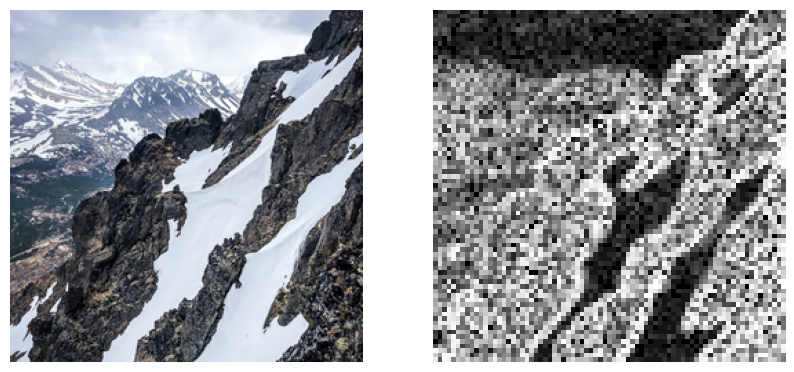

In [4]:
def preprocess(image):
    gamma = 2.2
    gamma_correction = np.array(255 * (image / 255) ** (1 / gamma), dtype='uint8')
    pre_image = cv2.cvtColor(gamma_correction, cv2.COLOR_BGR2GRAY)
    pre_image = cv2.resize(pre_image, None, fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
    pre_image = cv2.Laplacian(pre_image, cv2.CV_64F)
    pre_image = cv2.equalizeHist(cv2.convertScaleAbs(pre_image))
    # pre_image = cv2.resize(pre_image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    # pre_image = cv2.equalizeHist(pre_image)
    return pre_image

pre_image = preprocess(image)
compare_images(image, pre_image)

gabor filters bank

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from einops import rearrange

def gabor_features(image):
    height, width = image.shape[0], image.shape[1]
    orientations = np.linspace(0, np.pi, 10)
    wavelengths = np.arange(4, 24, 2)
    gabor_features = []

    for theta in orientations:
        for lambd in wavelengths:
            kernel = cv2.getGaborKernel((21, 21), 4.0, theta, lambd, 0, 0, ktype=cv2.CV_32F)
            filtered_img = cv2.filter2D(image, cv2.CV_32F, kernel)
            gabor_features.append(filtered_img)

    gabor_stack = np.stack(gabor_features, axis=0)
    feature_vectors = rearrange(gabor_stack, 'f h w -> (h w) f')  # Flatten spatial dimensions
    return feature_vectors, height, width

def gabor_features_rgb(image):
    channels = cv2.split(image)
    height, width = image.shape[:2]
    gabor_features_all_channels = []
    for channel in channels:
        orientations = np.linspace(0, np.pi, 10)
        wavelengths = np.arange(4, 24, 2)
        gabor_features_channel = []
        for theta in orientations:
            for lambd in wavelengths:
                kernel = cv2.getGaborKernel((11, 11), 4.0, theta, lambd, 0, 0, ktype=cv2.CV_32F)
                filtered_img = cv2.filter2D(channel, cv2.CV_32F, kernel)
                gabor_features_channel.append(filtered_img)

        gabor_features_channel_stack = np.stack(gabor_features_channel, axis=0)
        gabor_features_all_channels.append(gabor_features_channel_stack)

    gabor_features_combined = np.concatenate(gabor_features_all_channels, axis=0)  # Shape: (num_filters, height, width)
    feature_vectors = rearrange(gabor_features_combined, 'f h w -> (h w) f')
    return feature_vectors, height, width

# KMeans Clustering
def kmeans5(feature_vectors, height, width):
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(feature_vectors)
    segmented_img = rearrange(kmeans.labels_, '(h w) -> h w', h=height, w=width)  # Reshape to image
    return segmented_img

def kmeans3(feature_vectors, height, width):
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(feature_vectors)
    segmented_img = rearrange(kmeans.labels_, '(h w) -> h w', h=height, w=width)  # Reshape to image
    return segmented_img

# PCA for Dimensionality Reduction
# def pca(feature_vectors, height, width):
#     pca_result = PCA(n_components=2).fit_transform(feature_vectors)
#     segmented_img = rearrange(pca_result[:, 0], '(h w) -> h w', h=height, w=width)  # First principal component
#     return segmented_img

# Energy Map
def energy(feature_vectors, height, width):
    # Reshape feature vectors back to (num_filters, height, width)
    num_filters = feature_vectors.shape[1]
    gabor_stack = rearrange(feature_vectors, '(h w) f -> f h w', h=height, w=width, f=num_filters)
    
    # Compute energy map
    energy_map = np.sqrt(np.sum(gabor_stack**2, axis=0))  # Sum across filters
    return energy_map

# feature_vectors, height, width = gabor_features(pre_image)
# segmented_kmeans = kmeans(feature_vectors, height, width)
# segmented_pca = pca(feature_vectors, height, width)
# energy_map = energy(feature_vectors, height, width)

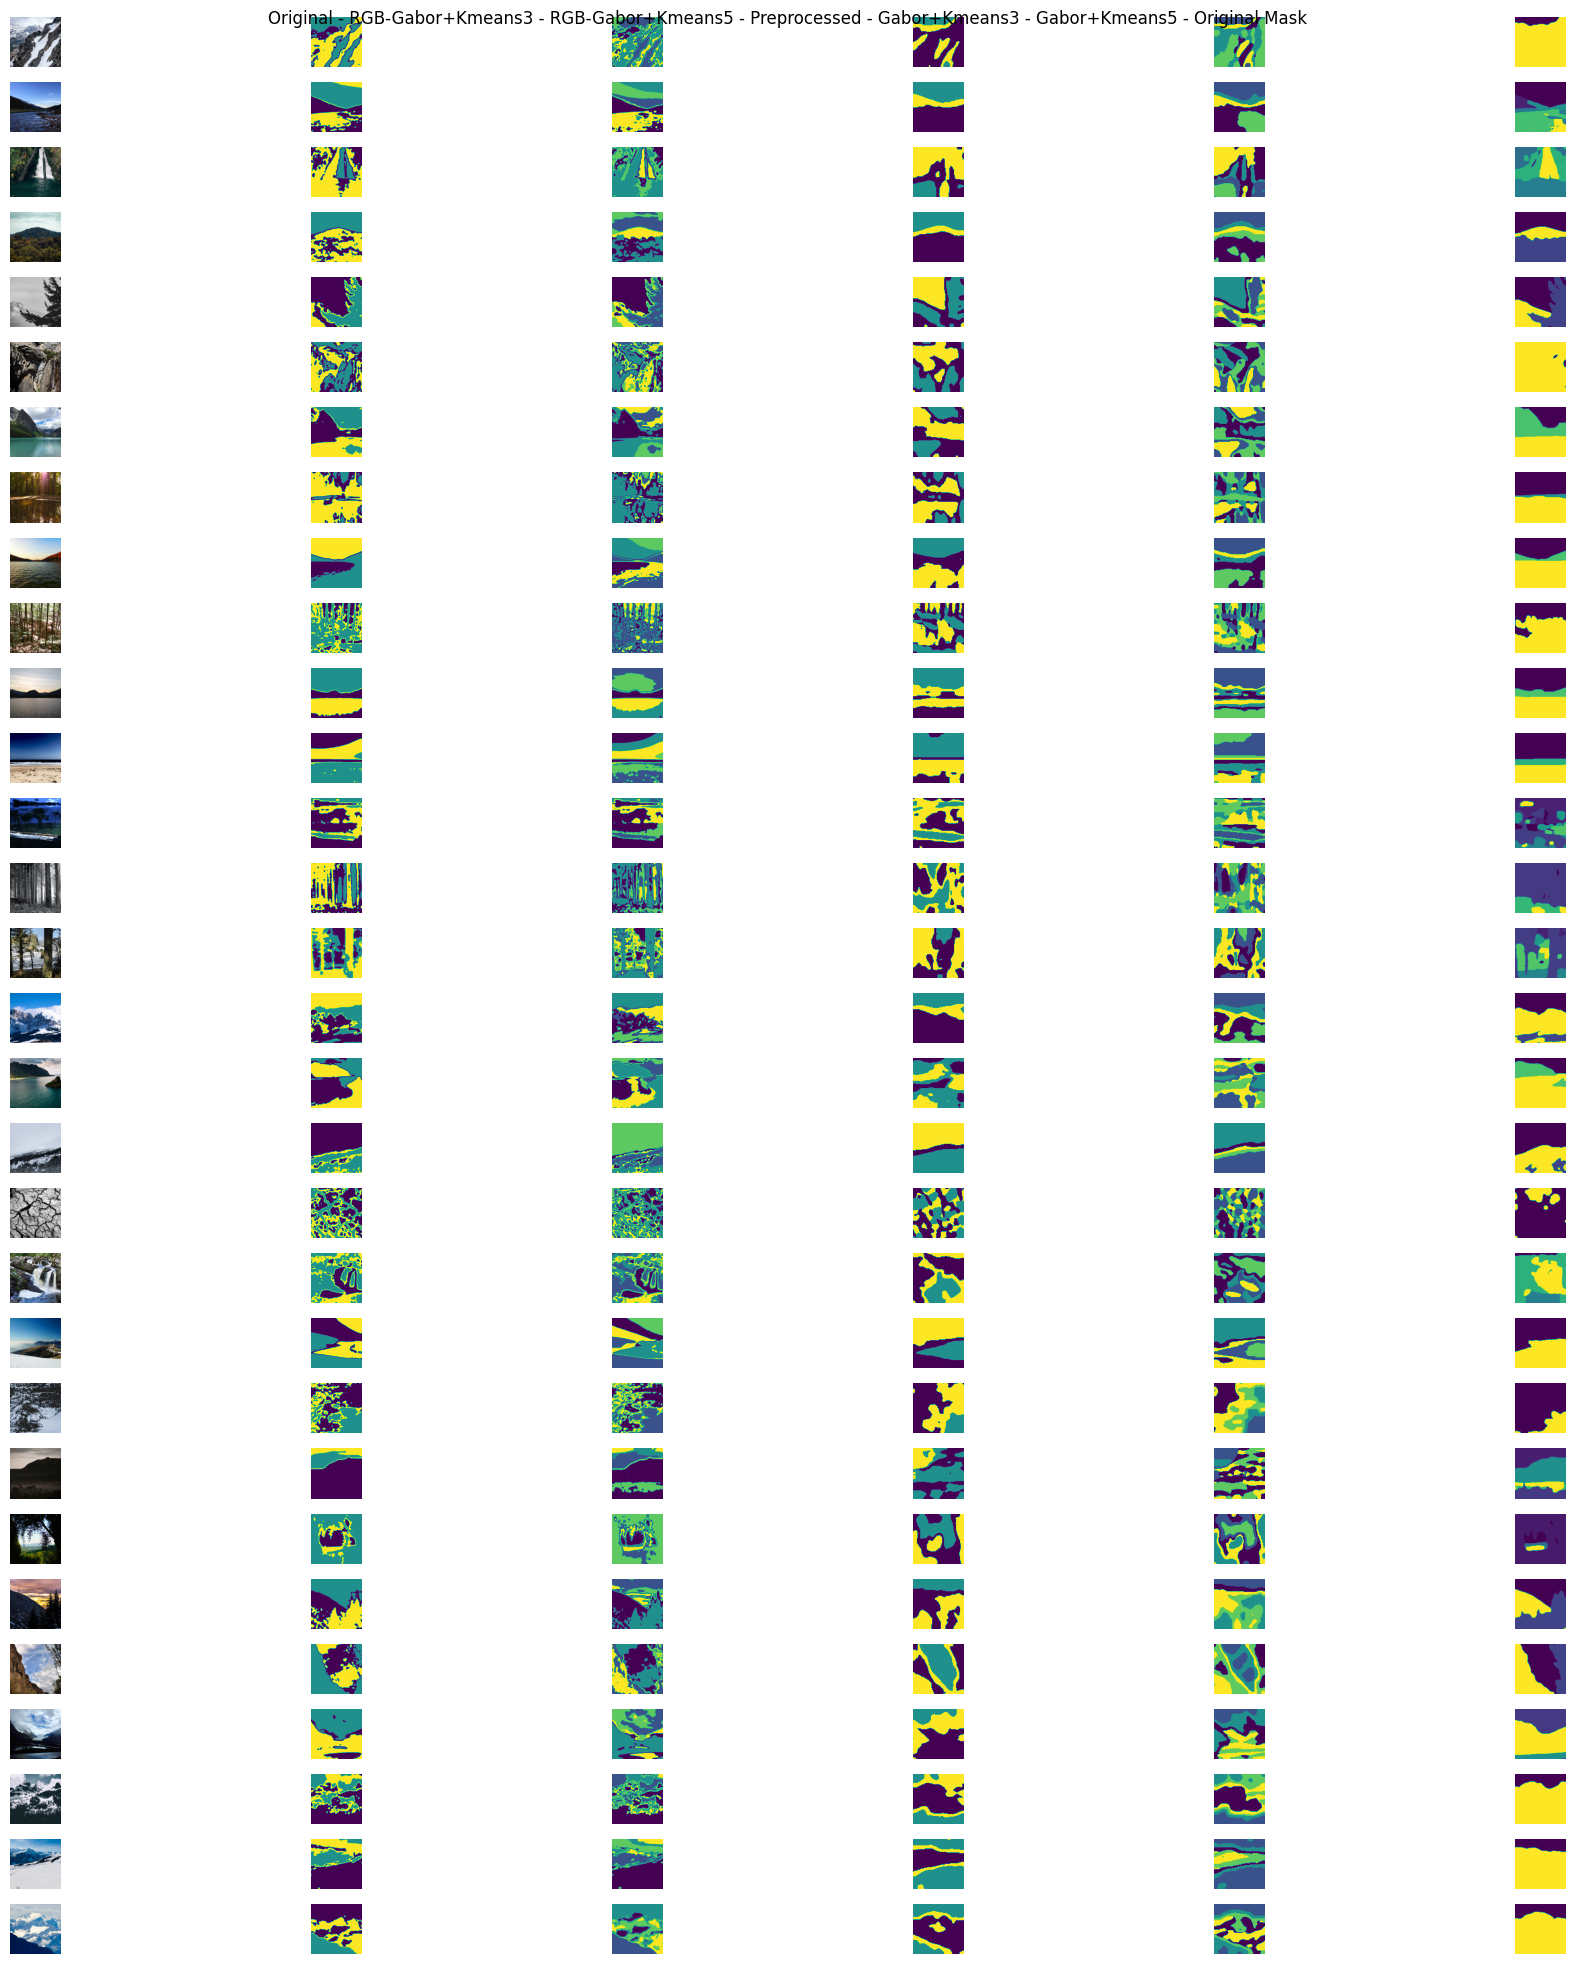

In [9]:
fig, axes = plt.subplots(n_images, 6, figsize=(20, 20))
for i in range(n_images):
    image, mask = data_loader.get_image(i)
    axes[i, 0].imshow(image, cmap='gray' if image.ndim == 2 else None)
    feature_vectors, height, width = gabor_features_rgb(image)
    axes[i, 1].imshow(kmeans3(feature_vectors, height, width), cmap='gray' if image.ndim == 2 else None)
    axes[i, 2].imshow(kmeans5(feature_vectors, height, width), cmap='gray' if image.ndim == 2 else None)
    
    pre_image = preprocess(image)
    #axes[i, 3].imshow(pre_image)

    feature_vectors, height, width = gabor_features(pre_image)
    axes[i, 3].imshow(kmeans3(feature_vectors, height, width))
    axes[i, 4].imshow(kmeans5(feature_vectors, height, width))
    axes[i, 5].imshow(mask)

for ax in axes.flatten():
    ax.axis('off')
fig.suptitle('Original - RGB-Gabor+Kmeans3 - RGB-Gabor+Kmeans5 - Preprocessed - Gabor+Kmeans3 - Gabor+Kmeans5 - Original Mask')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()